In [5]:
import torch
from xopt import Xopt
import yaml

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [6]:
X = Xopt(config=yaml_output)

In [7]:
X.step()

for i in range(5):
    print(f"step {i}")
    X.step()

step 0


/Users/chrisonian/Code/mambaforge/envs/xopt-dev/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1651023559589/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


step 1
step 2
step 3
step 4


In [8]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,1.977846,0.824265,dummy_constant,1.977846,0.824265,3.491346,2.289175,"[1, 2, 3]",False,
2,0.287308,0.324759,dummy_constant,0.287308,0.324759,-0.867870,0.075947,"[1, 2, 3]",False,
3,0.161698,2.533351,dummy_constant,0.161698,2.533351,5.391666,4.248966,"[1, 2, 3]",False,
4,1.344214,0.184002,dummy_constant,1.344214,0.184002,0.897712,0.812552,"[1, 2, 3]",False,
5,1.489616,1.940264,dummy_constant,1.489616,1.940264,5.033224,3.053702,"[1, 2, 3]",False,
6,0.850428,0.535089,dummy_constant,0.850428,0.535089,0.100067,0.124031,"[1, 2, 3]",False,
7,0.815845,0.507940,dummy_constant,0.815845,0.507940,0.010640,0.099821,"[1, 2, 3]",False,
8,0.719256,0.611086,dummy_constant,0.719256,0.611086,-0.136177,0.060413,"[1, 2, 3]",False,
9,0.824577,0.951113,dummy_constant,0.824577,0.951113,0.542623,0.308853,"[1, 2, 3]",False,
10,0.716560,1.127133,dummy_constant,0.716560,1.127133,0.877325,0.440194,"[1, 2, 3]",False,


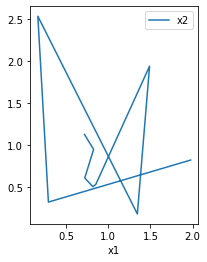

In [9]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

/Users/chrisonian/Code/mambaforge/envs/xopt-dev/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1651023559589/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


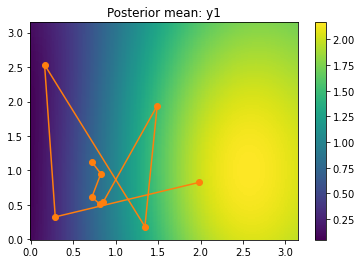

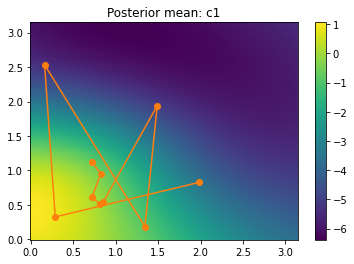

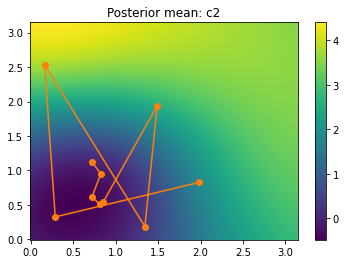

In [10]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "o-C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n))
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

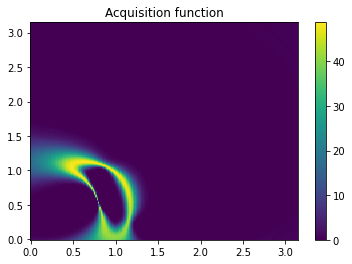

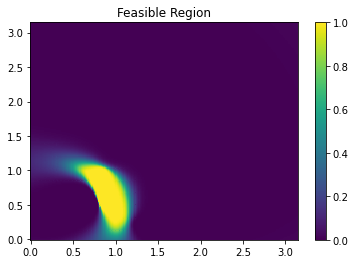

In [11]:
from xopt.generators.bayesian.utils import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")